In [1]:
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [58]:
URL_TRAIN_CSV = "https://gitlab.com/villainnumber1/filesml_proyecto_2/-/raw/main/train.csv"
URL_TEST_CSV = "https://gitlab.com/villainnumber1/filesml_proyecto_2/-/raw/main/test.csv"


X = pd.read_csv(URL_TRAIN_CSV, sep=",")
Y = pd.read_csv(URL_TEST_CSV, sep=",")

X

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,43161,3985,4,Lawrencez,40.0,856431180.0,Accountant,97384.44,8167.370000,1.0,...,Good,405.45,32.643281,336.0,No,77.284943,53.714219,High_spent_Large_value_payments,847.172909,Standard
1,40663,49494,2,Mohammedr,39.0,417453942.0,Writer,31369.58,2607.131667,8.0,...,Bad,4259.91,39.375507,144.0,Yes,171.748418,44.990811,High_spent_Large_value_payments,280.855383,Standard
2,111059,2925,6,Alistairn,17.0,499528888.0,Writer,30171.86,2772.321667,6.0,...,Bad,3406.51,34.039021,123.0,Yes,205.403926,40.781489,High_spent_Large_value_payments,247.322615,Standard
3,72139,21358,2,Dinesh Naire,22.0,859449371.0,Doctor,13100.02,1246.668333,7.0,...,Standard,727.29,34.747262,129.0,Yes,41.177132,23.005463,Low_spent_Large_value_payments,298.156832,Standard
4,119841,21221,4,Bakerg,26.0,485239890.0,Doctor,62313.54,5120.795000,6.0,...,Standard,817.64,24.545394,122.0,NM,196.679642,63.346750,Low_spent_Medium_value_payments,152.669902,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,42636,39869,7,Hendrik Sackmannb,50.0,217529489.0,Media_Manager,107761.29,9047.107500,4.0,...,Standard,34.09,41.899992,211.0,Yes,0.000000,150.220682,High_spent_Large_value_payments,984.123010,Standard
79996,114031,38305,2,Alexj,33.0,98861902.0,Scientist,16218.32,1098.526667,6.0,...,Bad,4466.33,24.275710,98.0,NM,64.533114,34.457893,High_spent_Small_value_payments,260.523798,Poor
79997,85991,9976,6,Luciana Lopezi,25.0,745835485.0,Engineer,29374.77,2377.897500,3.0,...,Standard,1189.37,38.439021,241.0,NM,40.264074,22.234178,High_spent_Medium_value_payments,403.980355,Standard
79998,21240,13193,7,Edward Krudyd,15.0,894419091.0,Manager,43782.45,3543.537500,6.0,...,Bad,3468.25,24.233841,85.0,Yes,240.664739,42.839562,Low_spent_Large_value_payments,146.741586,Poor


In [17]:
#
# Celda para hacer tests
#

var = "Interest_Rate"

blah = set(X[var]).union(set(Y[var]))
[ x for x in blah if len(str(x)) > 9 ][:10]

#s = set()
#for loan in list(blah):
#  loans = loan.split(", ")
#
#  for loan in loans:
#    if loan.startswith("and "):
#      loan = loan[4:]
#    s.add(loan)

#s

#len([acc for acc in X["Num_Bank_Accounts"] if acc == 0.0])
#len(X)

[]



---


**Heatmap**

---



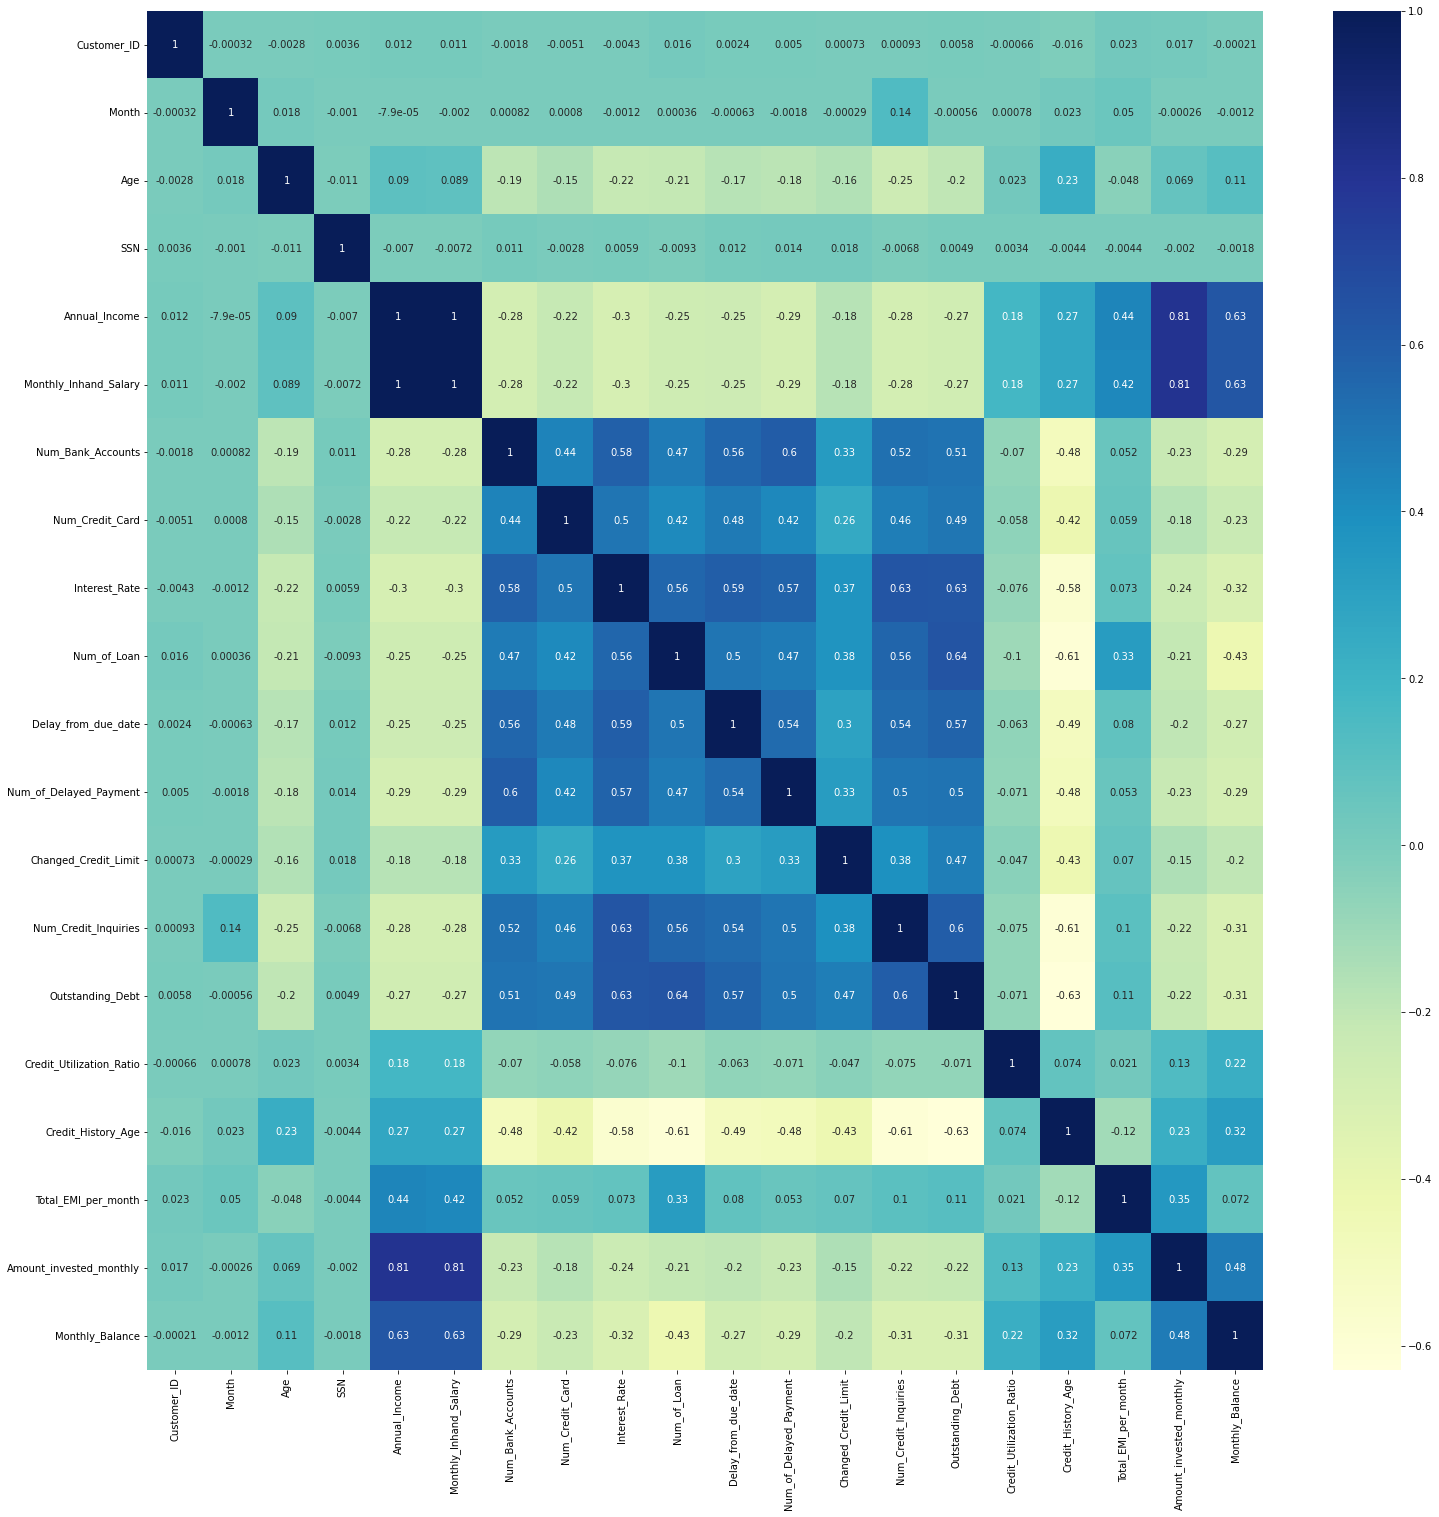

In [64]:
fig, ax = plt.subplots(figsize=(25,25))
data = X.drop(["ID"], axis = 1)

sns.heatmap(data.corr(),annot=True,cmap="YlGnBu", ax=ax)



---

**KDE**

---



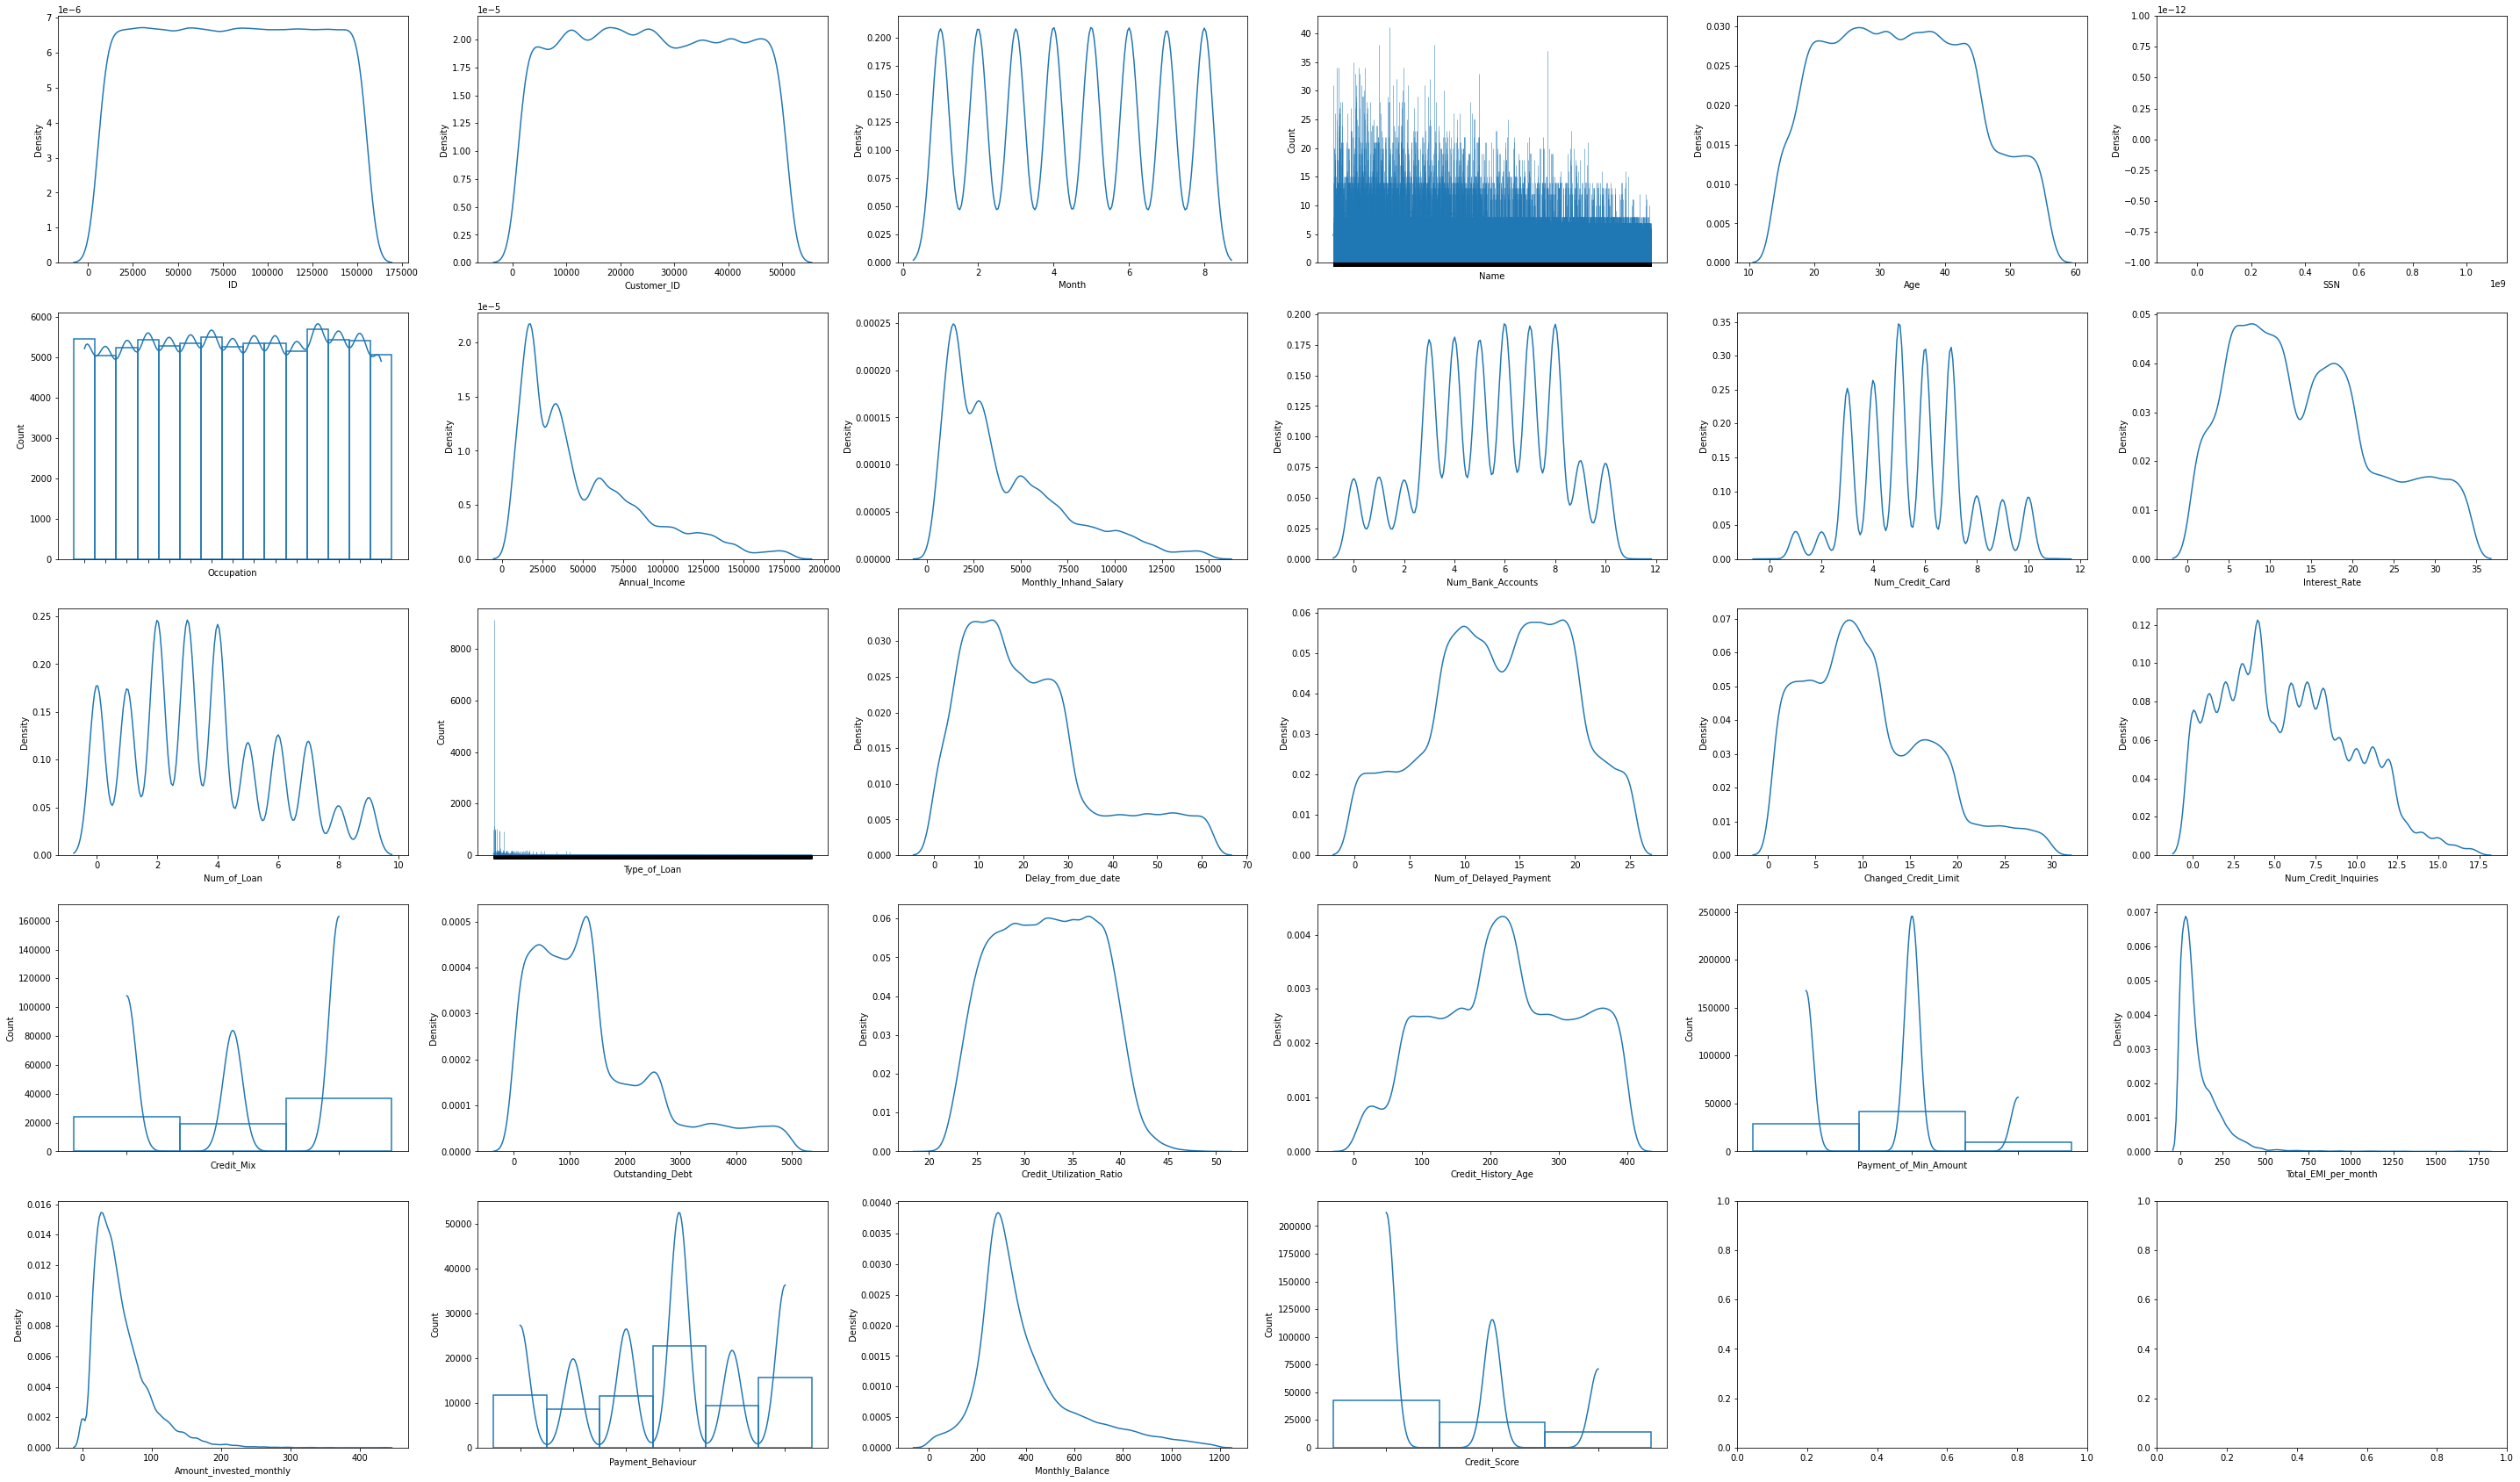

In [26]:
def kde(X, labels):
  # El numero de caracteristicas que tienen tipo numerico, para decidir las dimensiones
  n_of_numerical_features = len([ True for f in X if type(X[f][0]) != str ])
  
  fig, axs = plt.subplots(5, 6, figsize=(50, 30))
  #fig.delaxes(axs[2][3]) # Elimnar plots vacios
  
  i = 0
  for label in labels:
    if type(X[label][0]) != str:
      sns.kdeplot(X[label], ax=axs[i//6, i%6])
    else:
      aux = sns.histplot(X[label], ax=axs[i//6, i%6], kde=True, fill=False)
      #axs[i//4, i%4].tick_params(axis='x', rotation=90)

      #if label not in ["Ram", "OpSys"]:
      aux.set_xticklabels(aux.get_xticklabels(), rotation = 80, horizontalalignment = 'right')
    
    i += 1

kde(X, X.columns)




---

**Hipótesis sobre variables**


---



In [25]:
#-----------------------------------------------------------------------------------------------------------------------
#
# Idea: Usar regresión y categorizar los datos dependiendo del rango.
# 
# TODO: Observar patrones polinómicos.
# TODO: Equilibrar datasets entre aquellos que tienen un buen y un mal crédito bancario.
# TODO: Ejecutar analizador para juzgar que columnas merecen ser fusionadas.
#
#-----------------------------------------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------------------------------
# BACKGROUND
#
# America tiene tres sitemas de crédito diferentes:
#
# FICO (https://i.imgur.com/t0NuG0Z.png)
#   35% Payment history
#   30% Amounts owed
#   15% Length of credit history
#   10% New credit
#   10% Credit mix
#
# VantageScore (https://i.imgur.com/mTu4oiv.png)
#   40% Payment history
#   34% Amounts owed
#   21% Depth of credit
#   5%  Recent credit applications
#
# Credit Score
#   Rangos:
#     800 to 850: Excellent [ Individuals in this range are considered to be low-risk borrowers. They may have an easier time securing a loan than borrowers with lower scores.   ]
#     740 to 799: Very good [ Individuals in this range have demonstrated a history of positive credit behavior and may have an easier time being approved for additional credit. ]
#     670 to 739: Good [ Lenders generally view those with credit scores of 670 and up as acceptable or lower-risk borrowers. ]
#     580 to 669: Fair [ Individuals in this category are often considered “subprime” borrowers. Lenders may consider them higher-risk, and they may have trouble qualifying for new credit. ]
#     300 to 579: Poor [ Individuals in this range often have difficulty being approved for new credit. If you find yourself in the poor category, it's likely you'll need to take steps to improve your credit scores before you can secure any new credit. ]
#
# ----------------------------------------------------------------------------------------------------------------------

# Identificador de la entrada. Solo usable para CSV.
# Veredicto: Drop.
"ID"

# Identificador del cliente dentro de la BD
# Observación : Podría ser interesante ver como el crédito de un cliente evoluciona en el tiempo. Ensemble?
# Observación : Los datasets tienen varias entradas con los mismos clientes.
# Asunción    : Tiene correspondencia 1-1 con Name y SSN
# Veredicto   : Drop.
"Customer_ID"

# Mes en el que se registró la entrada en la BD.
# Hipótesis : El mes en el que se registra una entrada no tiene relación con el Credit_Score final, y si la tiene es muy pequeña.
# Veredicto : Drop.
#
"Month"

# Nombre de la persona en la entrada.
# Asunción  : Relación 1-1 con Customer_ID y SSN
# Veredicto : Drop.
"Name"

# Edad de la persona en la entrada.
# Asunción  : Cuanto más joven, menos probabilidad hay de que te den un crédito. ¿Pero solo por la edad?
# Veredicto : Normalizar.
"Age"

# Número de la seguridad social.
# Asunción  : Relación 1-1 con Customer_ID y Name
# Veredicto : Drop.
"SSN"

# Profesión de la persona.
# Hipótesis : Algunas profesiones tienen un salario medio más alto que otro, pero es dificil saberlo.
#             Algunas profesiones tienen claramente un salario medio más alto.
# Veredicto : Onehot para prevenir sesgos.
"Occupation"

# Salario anual.
# Observación : Números de coma flotante grandes.
# Observación : ES SIMPLEMENTE MONTHLY_INHAND_SALARY * 12
# Hipótesis   : Cuanto más alto, más alto el Credit_Score.
# Posibilidad : Categorizar en sesgos.
# Posibilidad : Drop en favor de Monthly_Inhand_Salary.
# Veredicto   : Normalizar.
"Annual_Income"

# Salario mensual después de impuestos y otras deducciones.
# Observación : Números de coma flotante grandes.
# Observación : ES SIMPLEMENTE ANNUAK_INCOME / 12
# Hipótesis   : (Falsa) Más valioso que Annual_Income ya que tiene en cuenta los impuestos.
# Veredicto   : Drop.
"Monthly_Inhand_Salary"

# Número de cuentas bancarias abiertas.
# Hipótesis : No afecta a Credit_Score (https://i.imgur.com/TuQKxmz.png).
# Veredicto : Drop.
"Num_Bank_Accounts"

# Número de tarjetas de crédito.
# Hipótesis : Afecta a Credit_Score negativamente (https://i.imgur.com/oN3M3Fj.png).
# Veredicto: Normalizar.
"Num_Credit_Card"

# Tipo de interés del cliente.
# Hipótesis   : ALTAMENTE RELACIONADA. Cuanto mayor es Credit_Score menor es Interest_Rate y viceversa. (https://i.imgur.com/PkTZIgP.png).
# Posibilidad : Categorizar.
# Veredicto   : Normalizar.
"Interest_Rate"

# Número de préstamos activos.
# Hipótesis   : Cuantos más préstamos se tengan, menor es Credit_Score. Cuanto peor se traten esos préstamos,
#               menor es Credit_Score (https://i.imgur.com/ewe3AUq.png).
# Veredicto   : Normalizar
"Num_of_Loan"

# Tipos de préstamos activos.
# Hipótesis   : Es más dificil conseguir préstamos para determinados tipos, como por ejemplo para una casa que además implica más cantidad de dinero.
# Veredicto   : OneHotEncoder para cada tipo.
"Type_of_Loan"

# Número medio de días de retraso en el pago de préstamos.
# Hipótesis   : Muy relacionada. Cuanto más alto es el número medio de días, peor es Credit_Score.
# Veredicto   : Normalizar.
"Delay_from_due_date"

# Número medio de pagos atrasados del cliente.
# Hipótesis   : Muy relacionada. Cuantos más pagos tenga retrasados, peor es Credit_Score.
# Veredicto   : Normalizar.
"Num_of_Delayed_Payments"

# Porcentaje de cambio en los límites de gasto del cliente.
# Observación : "El límite de cŕedito es la máxima cantidad de dinero que un prestamista te permite gastarte en una tarjeta de crédito o línea de crédito"
# Hipótesis   : El hecho de que cambie el límite de crédito implica que le han concedido más préstamos?
# Veredicto   : Normalizar.
"Changed_Credit_Limit"

# Número de consultas sobre tarjetas de crédito realizadas por el cliente.
# Hipótesis   : Tiene un pequeño impacto en Credit_Score (https://i.imgur.com/QiJ1cUC.png).
# Veredicto   : Normalizar.
"Num_Credit_Inquiries"

# Mezcla de tipos de cuentas de crédito que posee el cliente.
# Hipótesis   : Influye bastante (https://i.imgur.com/J59M5Du.png).
# Veredicto   : Onehot.
"Credit_Mix"

# Deuda en USD pendiente de pago.
# Hipótesis   : Cuanta más deuda se tenga, peor será Credit_Score.
# Observación : Depende del tipo de crédito. Algunos dicen que no empieza a perjudicarlo hasta tener bastante deuda.
# Veredicto   : Onehot.
"Outstanding_Debt"

# Ratio de uso de las tarjetas de crédito.
# Hipótesis   : Ayuda bastante a bajar Credit_Score (https://i.imgur.com/kWYfp9T.png).
# Posibilidad : Categorizar.
# Veredicto   : Normalizar.
"Credit_Utilization_Ratio"

# Antigüedad del historial de crédito.
# Hipótesis  : Ayuda bastante. Cuanto más antiguo es el historial de crédito, mejor es Credit_Score (https://i.imgur.com/O7QWboM.png).
# Veredicto  : Normalizar.
"Credit_History_Age"

# Representa si la persona sólo ha pagado el importe mínimo.
# Hipótesis   : Pagar solo la cantidad mínima puede afectar bastante a Credit_Score (https://i.imgur.com/LXyzHdI.png).
# Observación : Puede tener relación con el interés.
# Veredicto   : Passthrough.
"Payment_of_Min_Amount"

# Representa los pagos mensuales del EMI (en USD) (tasa mensual a la que se devuelve un préstamo).
# Hipótesis  : Cuanto más se pague cada mes, mayor es Credit_Score? Sin ningun fundamento.
# Veredicto  : Normalizar.
"Total_EMI_per_month"

# Cantidad en USD que el cliente invierte mensualmente.
# Hipótesis  : No afecta Credit_Score (https://i.imgur.com/aD4TpnJ.png).
# Veredicto  : Drop.
"Amount_invested_monthly"

# Comportamiento del cliente con respecto a los pagos.
# Observación : Es una enumeración.
# Hipótesis   : Afecta mucho por razones obvias.
# Idea        : OrdinalEncoder si hay un orden obvio.
# Veredicto   : Onehot.
"Payment_Behaviour"

# Balance mensual en USD.
# Observación : No creo que se refiera a la cantidad de dinero que se tiene en el banco al final del mes o el salario mensual.
# Hipótesis   : No esta claro como afecta Credit_Score (Forbes: https://i.imgur.com/GwGTjdd.png).
# Veredicto   : Drop.
"Monthly_Balance"

'Monthly_Balance'